# Machine Learning 521 Final Report
## Predicting Quarterly Earnings per Share with Time Series Data
#### RNN by Franco Rey
#### Gradient Boosted Regressor Trees by Hank Beck
#### Random Forest Regression by Bhavesh
#### Kmean Regime Clustering and Markov Chain by Kevin

# Introduction
    - What is the problem?
    - What are traditional methods for forecasting returns?
    - What is the benefit of machine learning to this problem
    - What models did we choose to explore


# Data

## Target
    - Reported EPS
    
## Features
    
## Data Sources
    - Yahoo finance
    - Alpha Vantage
    
## Things that needed to be accounted for
    - look ahead bias
    - Information available when predictions are to be made
    - Stationarity 
    - survivorship Bias
    
## Pros of the data set

## Cons of dataset

## Ways the dataset could be theorectically improved if more data available
    - longer time period
        

# Data Fetching and Cleaning
I will work here before merging with main so we have a backup in case someone messes up a merge with their independent branch

In [1]:
# import modules
import pandas as pd
import pandas_datareader as pdr
import requests
import os
from dotenv import load_dotenv
import csv
import numpy as np

# Modules for fetching data
import yfinance as yf

In [2]:
load_dotenv()
AV_api_key = os.getenv("ALPHA_VANTAGE_API_KEY")

## Helper functions

### Data retrieval and cleanup helper functions

In [3]:

def DeleteEmptyCSVs(CSVToCheck):
    # Function to delete any csvs that were created by an attempted data retrieval
    # but are empty of data
    if os.path.isfile(CSVToCheck):
        # Count the number of lines in the file
        with open(CSVToCheck, 'r') as file:
            reader = csv.reader(file)
            line_count = sum(1 for row in reader)
        
        print(f"The file {CSVToCheck} has {line_count} lines.")

        # Check if the line count is less 3 (header and empty line)
        if line_count < 3:
            print(f"{CSVToCheck} seems empty. Deleting the file.")
            os.remove(CSVToCheck)
        else:
            print(f"{CSVToCheck} seems to have data.")
    else:
        print(f"{CSVToCheck} does not exist.")

In [4]:
def getYahoo(tckr, tckr_csv):
    
    if not os.path.isfile(tckr_csv):
        print("Retrieving "+tckr+" Data from Yahoo...")
        try:
            tckr_data = yf.download(tckr, start=START_DATE_yahoo, end=END_DATE_yahoo)
            print("saving data to csv")
            tckr_data.to_csv(tckr_csv)
        except Exception as e:
            print(f"Failed to retrieve data: {e}")
    else:
        print(tckr+" data already saved in csv")



In [5]:
def getDividends(tckr):
    ticker = yf.Ticker(tckr)
    dividends_series = ticker.dividends
    csvFile = '.\data_files\\'
    csvFile = csvFile + tckr + 'dividends.csv'
    dividends_series.to_csv(csvFile)

In [6]:
def GetEarningsFromAlphaVantage(stock_ticker, data_folder = 'data_files'):
    # Request from API
    url = f'https://www.alphavantage.co/query?function=EARNINGS&symbol={stock_ticker}&apikey={AV_api_key}'
    response = requests.get(url)
    data = response.json()
    quarterly_file =  stock_ticker + 'quarterlyEarnings.csv'
    #annual_file =  stock_ticker + 'annualEarnings.csv'
    quarterly_csv = os.path.join(data_folder, quarterly_file)
    #annual_csv = os.path.join(data_folder, annual_file)
    # Parse the response to get EPS data and save it as a CSV file
    quarterly_earnings = data['quarterlyEarnings']
    #annual_earnings = data['annualEarnings']
    if not os.path.isfile(quarterly_csv):
        with open(quarterly_csv, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Fiscal Date','Estimated EPS', 'Reported EPS'])  # Write header row
            for earnings_data in quarterly_earnings:
                fiscal_date = earnings_data['fiscalDateEnding']
                estimated_eps = earnings_data['estimatedEPS']
                reported_eps = earnings_data['reportedEPS']
                writer.writerow([fiscal_date, estimated_eps, reported_eps])
    else:
        print("Quarterly Earnings CSV already present")
    # Report save
        
    print(f" Quarterly Earnings data saved to {quarterly_csv}")
    
    

In [7]:
def BalanceSheetFromAlphaVantage(stock_ticker, data_folder = 'data_files'):
    # Request from API
    url = 'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol=IBM&apikey=demo'
    response = requests.get(url)
    data = response.json()
    quarterly_file =  stock_ticker + 'quarterlyBalSheet.csv'
    #annual_file =  stock_ticker + 'annualEarnings.csv'
    quarterly_csv = os.path.join(data_folder, quarterly_file)
    #annual_csv = os.path.join(data_folder, annual_file)
    # Parse the response to get EPS data and save it as a CSV file
    quarterly_reports = data['quarterlyReports']
    #annual_earnings = data['annualEarnings']
    if not os.path.isfile(quarterly_csv):
        with open(quarterly_csv, mode='w', newline='') as file:
            writer = csv.writer(file)
            balance_sheet_items = list(quarterly_reports[0].keys())
            writer.writerow(balance_sheet_items)  # Write header row
            for report in quarterly_reports:
                curr_row = []
                for item in balance_sheet_items:
                    curr_row.append(report[item])
                writer.writerow(curr_row)
    else:
        print("Quarterly Earnings CSV already present")
    # Report save
        
    print(f" Quarterly Earnings data saved to {quarterly_csv}")
    
    

## Fetching Initial Data

### Sourced from yahoo

In [8]:
START_DATE_yahoo ="1990-01-01"
END_DATE_yahoo = "2024-05-30"

# Larger Market trends 

# S&P 500
sp500_ticker = '^GSPC'
sp500_csv = '.\data_files\sp500_RawData.csv'
START_DATE_sp500 = START_DATE_yahoo
END_DATE_sp500 = END_DATE_yahoo

# CBOE Volatility Index (VIX)
vix_ticker = '^VIX'
vix_csv = '.\data_files\VIX_RawData.csv'
START_DATE_vix = START_DATE_yahoo
END_DATE_vix = END_DATE_yahoo

# Large Cap Stocks

# Microsoft (MSFT)
micro_ticker = 'MSFT'
micro_csv = '.\data_files\MSFT_RawData.csv'
micro_earnings_csv = '.\data_files\MSFTquarterlyEarnings.csv'
micro_balSht_csv = '.\data_files\MSFTquarterlyBalSheet.csv'
START_DATE_msft = START_DATE_yahoo
END_DATE_msft = END_DATE_yahoo

# General Electric (GE)
general_elec_ticker = 'GE'
ge_csv = '.\data_files\GE_RawData.csv'
START_DATE_ge = START_DATE_yahoo
END_DATE_ge = END_DATE_yahoo

# Johnson and Johnson (JNJ)
jj_ticker = 'JNJ'
jj_csv = '.\data_files\JNJ_RawData.csv'
jj_earnings_csv = '.\data_files\JNJquarterlyEarnings.csv'
jj_balSht_csv = '.\data_files\JNJquarterlyBalSheet.csv'
jj_dividend_csv = '.\data_files\JNJdividends.csv'
START_DATE_jj = START_DATE_yahoo
END_DATE_jj = END_DATE_yahoo

# Coca Cola (KO)
cc_ticker = 'KO'
cc_csv = '.\data_files\KO_RawData.csv'
START_DATE_cc = START_DATE_yahoo
END_DATE_cc = END_DATE_yahoo


## S&P 500 (representative of of larger market trends)

In [ ]:
#getYahoo(sp500_ticker, sp500_csv)

## VIX (overall market volatility)

In [ ]:
#getYahoo(vix_ticker,vix_csv)

## Johnson and Johnson Historical Stock Price

In [ ]:
#getYahoo(jj_ticker, jj_csv)

## Microsoft Historical Stock Price

In [ ]:
#getYahoo(micro_ticker,micro_csv)

## Dividend data

In [ ]:
#getDividends(jj_ticker)

In [ ]:
#getDividends(micro_ticker)

# Alpha Vantage Accounting Data

In [ ]:
#BalanceSheetFromAlphaVantage(stock_ticker=micro_ticker)
#GetEarningsFromAlphaVantage(stock_ticker= micro_ticker)

In [ ]:
#BalanceSheetFromAlphaVantage(stock_ticker=jj_ticker)
#GetEarningsFromAlphaVantage(stock_ticker= jj_ticker)

# FROM CSVs Create Collated Data Frame

Features to Extract:

    - reported Earnings Per Share
    - Total Assets
    - Accruals 
    - Equity Ratio 
    - Cash Dividends Paid Since last Quarter
    - VIX Lagged By By several steps out
        - Can achieve some granularity this way despite looking to make quarterly predictions for earnings
    - S&P Lagged for several steps 
        - Can provide information on how it has moved over the last several weeks not just quarter to quarter snapshots 

In [9]:
Market_Features_to_drop = ['Volume','High','Low','Adj Close']
Balance_sheet_features_to_keep = ['totalAssets','totalShareholderEquity']

# Get Price Data
SP500_raw_df = pd.read_csv(sp500_csv, index_col = 'Date')
VIX_raw_df = pd.read_csv(vix_csv, index_col = 'Date')
JJ_raw_price_df = pd.read_csv(jj_csv, index_col = 'Date')

# Get Quarterly Data
JJ_Earnings_df = pd.read_csv(jj_earnings_csv)
JJ_Earnings_df['Date'] = pd.to_datetime(JJ_Earnings_df['Fiscal Date'])
JJ_Earnings_df.drop(columns = ['Fiscal Date'], inplace = True)
JJ_Earnings_df.set_index('Date', inplace = True)
JJ_Earnings_df =  JJ_Earnings_df.iloc[::-1]

JJ_BalSht_df = pd.read_csv(jj_balSht_csv)
JJ_BalSht_df['Date'] = pd.to_datetime(JJ_BalSht_df['fiscalDateEnding'])
JJ_BalSht_df.drop(columns = ['fiscalDateEnding'], inplace = True)
JJ_BalSht_df.set_index('Date', inplace = True)
JJ_BalSht_df =  JJ_BalSht_df.iloc[::-1]

# get Dividend Data
JJ_dividend_df = pd.read_csv(jj_dividend_csv)
JJ_dividend_df['Date'] = JJ_dividend_df['Date'].str.split().str[0]
JJ_dividend_df.set_index('Date', inplace = True)

# drop market feature form S&P and VIX
SP500_raw_df.drop(columns= Market_Features_to_drop, inplace= True)
VIX_raw_df.drop(columns=Market_Features_to_drop, inplace= True)

# drop high and low
JJ_raw_price_df.drop(columns=['High','Adj Close', 'Low'], inplace=True)

# Calculate daily return
SP500_raw_df['Daily_Return_dollars'] = SP500_raw_df['Close'] - SP500_raw_df['Open']
VIX_raw_df['Daily_Return_dollars'] = VIX_raw_df['Close'] - VIX_raw_df['Open']

SP500_raw_df['Daily_Return_percent'] = SP500_raw_df['Daily_Return_dollars']/SP500_raw_df['Open']
VIX_raw_df['Daily_Return_percent'] = VIX_raw_df['Daily_Return_dollars']/VIX_raw_df['Open']

JJ_raw_price_df['Daily_Return_dollars'] = JJ_raw_price_df['Close'] - JJ_raw_price_df['Open']
JJ_raw_price_df['Daily_Return_percent'] = JJ_raw_price_df['Daily_Return_dollars']/JJ_raw_price_df['Open']

# drop open and close
JJ_raw_price_df.drop(columns=['Open','Close','Daily_Return_dollars'], inplace = True)
SP500_raw_df.drop(columns=['Open','Close','Daily_Return_dollars'], inplace = True)
VIX_raw_df.drop(columns=['Open','Close','Daily_Return_dollars'], inplace = True)

# Balance Sheet Features
JJ_Bal_Sheet_reduced_df = JJ_BalSht_df.loc[:,Balance_sheet_features_to_keep]
JJ_Bal_Sheet_reduced_df['Equity Ratio'] = JJ_Bal_Sheet_reduced_df['totalShareholderEquity'] /JJ_Bal_Sheet_reduced_df['totalAssets']
JJ_Bal_Sheet_reduced_df.drop(columns=['totalShareholderEquity'], inplace = True)

# JJ merge
JJ_market_df = JJ_dividend_df.merge(JJ_raw_price_df, left_index=True, right_index=True)
JJ_market_df.index = pd.to_datetime(JJ_market_df.index)
JJ_earnbal_df = JJ_Earnings_df.merge(JJ_Bal_Sheet_reduced_df, left_index = True, right_index = True)
JJ_merge_df = JJ_market_df.merge(JJ_earnbal_df,how = 'outer', left_index= True, right_index= True)

# Merge Raw Data
market_df = SP500_raw_df.merge(VIX_raw_df, left_index=True, right_index=True,suffixes=('_SP','_VIX'))
market_df.index = pd.to_datetime(market_df.index)

merged_df = market_df.merge(JJ_merge_df, how = 'outer', left_index= True, right_index= True)
# Display Data Frame Head
merged_df.head()

,Daily_Return_percent_SP,Daily_Return_percent_VIX,Dividends,Volume,Daily_Return_percent,Estimated EPS,Reported EPS,totalAssets,Equity Ratio
Date,,,,,,,,,
1990-01-02,0.017799,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,-0.002586,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,-0.008613,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,-0.009756,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,0.004514,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Summary of the Final Features/ Target and train test split

# RNN (Franco)

## Why this model for this problem

* Recurrent nerual networks are specifically designed to handle sequential data, ideal for time-series forecasting. gated neural networks like the LSTM offer nuanced pattern recognition and adapt to macroeconomic trends and cycles over time.

## Model Architecture

Our RNN will utilize a Long Short Term Memory Model, as justified by its advantages for time series.

Preparing the data, declaring the batch size and obtaining the number of features.

In [10]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

batch_size = 64
n_features = merged_df.shape[1]

# `merged_df` needs numeric types no missing values
data = merged_df.values

Given data limitations we apply a forward fill, backward fill, and fill with mean to ensure that missing values in the dataframe are cleaned up.

In [11]:
# Forward Fill
merged_df.ffill(inplace=True)

# Backward Fill
merged_df.bfill(inplace=True)

# Fill with Mean 
merged_df.fillna(merged_df.mean(), inplace=True)


Here the data is properly normalized, and then reevaluated to solve any NaN and Inf values. Initially, a StandardScaler approach was used until it resulted in notable bias. Switching to a MinMax scaler from 0 to 1 fit the data better.

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Apply MinMaxScaler for better normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(merged_df.values)

# Ensure no infinite or NaN values after scaling
data_scaled = np.nan_to_num(data_scaled)

# Ensure no infinite or NaN values after scaling
if np.isinf(data_scaled).any() or np.isnan(data_scaled).any():
    print("Infinite or NaN values found after scaling.")
    data_scaled = np.nan_to_num(data_scaled)  # Replace NaNs and Infs


Here the dataset is transformed into sequences, and split into training and testing data.

In [13]:
# Reshape data to fit the RNN input shape
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :])
        y.append(data[i, 5])  # Assuming the first column is the target variable
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, n_steps)

# Split the dataset
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Here we define the RNN model. The model consists of two LSTM layers, two dropout layers, and one dense layer.

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

n_steps = 50  
n_features = merged_df.shape[1]  

# Define the RNN model
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(n_steps, n_features), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Output layer - assumes a single output per sequence
])

# Display model summary to verify its structure
model.summary()


C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,251 (125.98 KB)

 Trainable params: 32,251 (125.98 KB)

 Non-trainable params: 0 (0.00 B)

Compile the model using Stochastic Gradient Descent.

In [15]:
# Compile the model using SGD optimizer
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=sgd_optimizer, loss='mean_squared_error')

Run the epochs to train the model.

In [16]:
history = model.fit(X_train, y_train, epochs=400, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/400
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0014 - val_loss: 0.0522
Epoch 2/400
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9236e-04 - val_loss: 0.0498
Epoch 3/400
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4469e-04 - val_loss: 0.0497
Epoch 4/400
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1661e-04 - val_loss: 0.0493
Epoch 5/400
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7618e-04 - val_loss: 0.0483
Epoch 6/400
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8541e-04 - val_loss: 0.0484
Epoch 7/400
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6737e-04 - val_loss: 0.0478
Epoch 8/400
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2768e-04 - val_loss: 0.0479
Epoch 9/400
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2401e-04 - val_loss: 0.0463
Epoch 10/400
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4610e-04 - val_loss: 0.0469
Epoch 11/400
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3674e-04 - val_loss: 0.0472
E

Here we plot the actual and predicted values of our earnings per share.

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


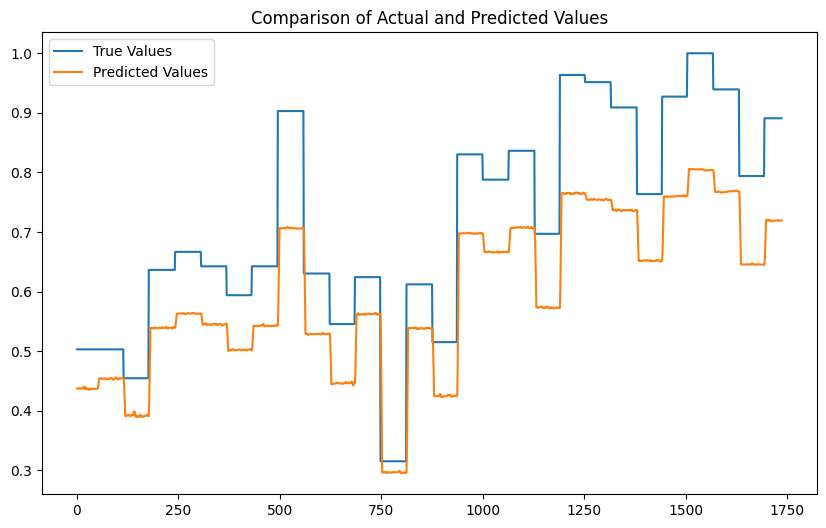

In [17]:
import matplotlib.pyplot as plt

# Predicting
predicted_values = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

In [18]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 0.0110
Test Loss: 0.01744702085852623


## Model Specific Preprocessing 

## Model Specific Tuning

## Model Evaluation

## Fitted Model and Results
    - Report on hyper parameters
    - Report on fit quality
    - Ideas on improvement if the model was continued to be

## RNN results (Franco)


# XGBoost (Hank)
## Why this model for this problem
## Model Architecture
## Model Specific Preprocessing 
## Model Specific Tuning
## Model Evaluation

## Fitted Model and Results
    - Report on hyper parameters
    - Report on fit quality
    - Ideas on improvement if the model was continued to be

# Random Forest (Bhavesh)
## Why this model for this problem
## Model Architecture
## Model Specific Preprocessing 
## Model Specific Tuning
## Model Evaluation

## Fitted Model and Results
    - Report on hyper parameters
    - Report on fit quality
    - Ideas on improvement if the model was continued to be

# Kmeans Regimes + Markov Chain (Kevin)
## Why this model for this problem
## Model Architecture
## Model Specific Preprocessing 
## Model Specific Tuning
## Model Evaluation

## Fitted Model and Results
    - Report on hyper parameters
    - Report on fit quality
    - Ideas on improvement if the model was continued to be